In [1]:
#
#* 데이터 경로 설정
root_dir = !pwd
root_dir = root_dir[0]
# !mkdir -p data_demo
# %cd data_demo
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
# %cd ..
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
scene_id = "2t7WUuJeko7_2_mini"
data_dir = os.path.join(root_dir, "Data/habitat_sim/", scene_id)#/vlmaps_dataset
version = "dummy"
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth


In [2]:
#
#* setup VLMaps parameters
# @markdown meters per cell size
cs = 0.025 # @param {type: "number"} #* 셀 크기 당 미터 단위
# @markdown map resolution (gs x gs)
gs = 2000 # @param {type: "integer"} #* 맵의 해상도 (그리드 수 _ 정수 단위)
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"} #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"} #* depth 정보의 픽셀 sampling rate
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"} #* 데이터 경로

In [3]:
# @title Helper functions for VLMap Creation
#* VLMap 제작 함수!

import os
import math

import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import clip

from map.utils.mapping_utils import load_pose, save_map, depth2pc, transform_pc, get_sim_cam_mat, pos2grid_id, project_point, load_semantic_npy, cvt_obj_id_2_cls_id, load_obj2cls_dict

"""
& load_pose : pose.txt 파일 ㅌ하나를 읽어서 7개의 숫자 중 앞쪽 3개는 pos로, 뒤쪽 4개는 rot 정보로 읽어서 (pos,rot)를 반환
& save_map : npy 배열 형태의 color_top_down, grid, weight, obstacles 저장
& depth2pc : depth 정보를 이용해 point cloud 생성 (3xN 사이즈의 array 반환)
    ! 저 utils안에 depth2pc_aithor, depth2pc_real_world 등 두 개의 함수 추가로 존재, 이걸로도 가능한지 확인 필요, 성능 확인 필요
    ? 관련 url
        https://medium.com/@ramazanilkera2/rgbd-to-3d-point-cloud-223b0a6f46db
        https://www.google.com/search?q=depth+to+point+cloud&oq=depth+to+point+cloud&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQLhhA0gEJMTQ1ODZqMGo5qAIAsAIA&sourceid=chrome&ie=UTF-8
        https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f
        https://github.com/HarendraKumarSingh/stereo-images-to-3D-model-generation/blob/master/depth-map-to-3D-point-cloud.ipynb
& transform_pc : point cloud를 robot coo.에서 global coo.으로 변환해주는 함수?
& get_sim_cam_mat : point cloud의 projection matrix에서 3x3 부분을 반환해주는 함수
& pos2grid_id : 좌표계를 grid기반으로 바꿔주는 함수로, 맵의 크기를 반으로 나누어 중심에서부터 시작해 좌표값을 한 grid당 거리로 나누어 중심으로부터 떨어진 거리를 구해 더하여 grid 기반의 좌표, 즉 id로 바꿈
& project_point : p local을 rgb나 pix_feat의 투영행렬을 이용해 각각의 차원으로 투영해주는 함수
"""

from map.lseg.modules.models.lseg_net import LSegEncNet #* LSeg model
from map.lseg.additional_utils.models import resize_image, pad_image, crop_image

"""
& resize_image : 
& pad_image :
& crop_image :
"""



#* 이 함수를 사용해 VLMaps 제작!
def create_lseg_map_batch(img_save_dir, camera_height, cs=0.05, gs=1000, depth_sample_rate=100):
    mask_version = "lseg" # 0, 1

    crop_size = 480 # 480
    base_size = 520 # 520
    lang = "door,chair,ground,ceiling,other"
    labels = lang.split(",")

    # loading models
    #^ 이 섹션의 목표는 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)
    clip_version = "ViT-B/32" #! clip ckpt 이름!!!! https://huggingface.co/openai/clip-vit-base-patch32/tree/main 이거이거! / https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt 깃헙! /https://github.com/openai/CLIP/blob/main/clip/clip.py 여기서 확인 가능! / https://huggingface.co/docs/transformers/model_doc/clip
                                #* https://velog.io/@dongdori/CLIP2021-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0 간단 설명
            #^ /home/hong/capstone/vlmaps_demo/vlmaps/lseg/modules/models/lseg_net.py 여기서 LSEgencNet 봐보면 ckpt별로 다르게 out_c가 지정되어있는 것을 확인할 수 있으며, 우리의 모델의 경우 512라는 것을 알 수 있음!
            #^ clip version은 따로 다운 받은게 아니라, clip이라는 라이브러리에서 제공하는 것을 사용!
    clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                    'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
    print("Loading CLIP model...")
    clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
    clip_model.to(device).eval()
    lang_token = clip.tokenize(labels)
    lang_token = lang_token.to(device)
    with torch.no_grad():
        text_feats = clip_model.encode_text(lang_token)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    text_feats = text_feats.cpu().numpy()
    model = LSegEncNet(lang, arch_option=0, #* 그냥 lseg 파라미터자너
                        block_depth=0,
                        activation='lrelu',
                        crop_size=crop_size)
    model_state_dict = model.state_dict()
    pretrained_state_dict = torch.load("/home/hong/VLMAPS/VLN/vlmaps/vlmaps/lseg/checkpoints/demo_e200.ckpt")
    pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
    model_state_dict.update(pretrained_state_dict)
    model.load_state_dict(pretrained_state_dict) #* 그냥 lseg 모델 정의한거고

    model.eval()
    model = model.cuda()

    norm_mean= [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
    padding = [0.0] * 3
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    print(f"loading scene {img_save_dir}")
    rgb_dir = os.path.join(img_save_dir, "rgb")
    depth_dir = os.path.join(img_save_dir, "depth")
    pose_dir = os.path.join(img_save_dir, "pose")
    semantic_dir = os.path.join(img_save_dir, "semantic")
    # obj2cls_path = os.path.join(img_save_dir, "obj2cls_dict.txt")

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    semantic_list = sorted(os.listdir(semantic_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pose_list = [os.path.join(pose_dir, x) for x in pose_list]
    semantic_list = [os.path.join(semantic_dir, x) for x in semantic_list]


    #^ output은 color_top_down, grid, weight, obstacles로 저장됨
    #! https://huggingface.co/ai-forever/ruclip-vit-base-patch32-384
    map_save_dir = os.path.join(img_save_dir, "map")
    os.makedirs(map_save_dir, exist_ok=True)
    color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{mask_version}.npy") #* 말 그대로 위에서 내려다본 rgb맵
    gt_save_path = os.path.join(map_save_dir, f"grid_{mask_version}_gt.npy")
    grid_save_path = os.path.join(map_save_dir, f"grid_lseg_{mask_version}.npy") #* 각 그리드에 semantic segmentation결과 class별 확률 정보를 저장해둔 맵
    weight_save_path = os.path.join(map_save_dir, f"weight_lseg_{mask_version}.npy") #* semantic segmentation이 여러 이미지에 이루어지니 겹쳐지는 그리드 발생, 각 그리드 별로 몇번 겹쳐졌는지 저장한 맵
                                                                                    #* 이는, semantic 대표값을 여러번의 segmentation의 평균으로 했기에 사용됨 (각 segmentation class별 확률의 평균)
    obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{mask_version}.npy") #* 말 그대로 0,1로 이루어진 obstacle맵

    # obj2cls = load_obj2cls_dict(obj2cls_path)

    # initialize a grid with zero position at the center
    color_top_down_height = (camera_height + 1) * np.ones((gs, gs), dtype=np.float32) #* color_top_down에서 height를 비교해 더 낮은 height를 가질 때의 rgb값을 저장하기 위해 사용됨
    color_top_down = np.zeros((gs, gs, 3), dtype=np.uint8)
    gt = np.zeros((gs, gs), dtype=np.int32)
    grid = np.zeros((gs, gs, clip_feat_dim), dtype=np.float32)
    obstacles = np.ones((gs, gs), dtype=np.uint8) #* gs*gs의 정사각형 모양 맵이네 뭐지?왜? 아 그냥 크게 여유있게 gs를 잡아뒀으니깐 (그 맵 나온거 보면 까맣게 비어있는 곳 넓자너)
    weight = np.zeros((gs, gs), dtype=float)

    save_map(color_top_down_save_path, color_top_down)
    # save_map(gt_save_path, gt)
    save_map(grid_save_path, grid)
    save_map(weight_save_path, weight)
    save_map(obstacles_save_path, obstacles)

    tf_list = []
    data_iter = zip(rgb_list, depth_list, pose_list, semantic_list)
    pbar = tqdm(total=len(rgb_list))
    # load all images and depths and poses










    """
    *데이터 차원!!
    *depth : (720,1080)
    *rgb : (720, 1080, 3)
    *semantic segmentation 결과 : (1,512,347,520)
    """

    #* 여기서부터 시작!!! (앞은 경로 설정이랑 cuda, 모델 로드 등)
    for data_sample in data_iter:
        rgb_path, depth_path, pose_path, semantic_path = data_sample
        
        # read rgb
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        # read pose
        pos, rot = load_pose(pose_path)  # z backward, y upward, x to the right #* 이걸 통해 나온 ros는 쿼터니안이 회전행렬 형태로 변환된 것
        rot_ro_cam = np.eye(3) 
        rot_ro_cam[1, 1] = -1
        rot_ro_cam[2, 2] = -1 #* [[1,0,0],[0,-1,0],[0,0,-1]] -> y, z축 각각 반전!
        rot = rot @ rot_ro_cam #! rot 뛰에 변환행렬 곱했네 뭐겠어 local coo.을 global coo.으로 바꾸는 거겠지
        pos[1] += camera_height #! 기존 pos값은 이미지에서의 높이이니, 그 아래의 카메라 높이만큼 더해줘야됨
        """
        In the code, we use the default robot coordinate frame that Habitat-Sim uses: z backward, x right, y up. So the position of the camera relative to the robot frame should be camera_height above the robot frame (in y direction), so the last line of the code is pos[1] += camera_height       
        """
        pose = np.eye(4)
        pose[:3, :3] = rot
        """
        ? ? ? 0
        ? ? ? 0
        ? ? ? 0
        0 0 0 1
        """
        pose[:3, 3] = pos.reshape(-1) #* 행벡터를 열벡터로 치환해 대입 ->rotation matrix, translation matrix 모두 포함된 transformation matrix
        """
        R T 
        0 1
        """

        tf_list.append(pose) #* 아마 각 pose마다의 변환행렬 (변환행렬 변수명이 pose임)을 리스트 형태로 저장하려는듯
        if len(tf_list) == 1:
            init_tf_inv = np.linalg.inv(tf_list[0])  #* 첫번째인 경우엔 전의 기록이 없으니 역행렬을 구해줌

        tf = init_tf_inv @ pose #* robot coo.을 global coo.으로 변형하기 위한 matrix
                                #! 첫번째의 경우 pose와 pose의 역행렬이 곱해지니 첫번째 tf는 단위행렬이 됨
                                #! 봐봐 생각을 해봐 첫번째의 경우엔 이동을 안했잖아 그러니깐 그냥 global = local이라고 생각하고 하면 되니깐 변환행렬도 단위 행렬인거지
                                #! 반면에 그 다음부터는 이전의 이동이 계속 누적되었으니 그걸 감안한 변환행렬을 사용해야될 것이고

        # read depth
        depth = load_depth(depth_path)
        # read semantic
        semantic = load_semantic_npy(semantic_path)
        # semantic = cvt_obj_id_2_cls_id(semantic, obj2cls) #! here
        #! LSeg 모델을 사용해 semantic segmentation 진행, 그 확률 map을 반환해 pix_feats에 저장
        #* pix_feats의 차원 : (1, 512, 347, 520) 흠.... (배치크기, 픽셀 임베딩 벡터의 차원, height, width)
            #! rgb랑 depth는 크기가 동일한 것을 보니 얘는 semantic segmentation 과정에서 pad, trim 등의 과정에 영향을 받은 듯
        pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)





        # transform all points to the global frame
        #* pc획득하고 다운샘플링 진행 - sampling rate은 위쪽 셀에서 수정 가능
        """
            ! 여기서 shuffle이 들어가도 상관없는 이유
            * -> mask랑 같이 pc도 같이 shuffle되고, pc 안에는 x,y,z정보가 이미 담겨있음
            * -> 따라서 벡터 요소 순서가 바뀌어도 위치 정보는 벡터 순서가 아닌 value로 담고 있기에 바뀌어도 상과 없다!

            ! 그렇다면, shuffle하는 이유와 depth의 down sampling을 진행하는 이유는 무엇인가
            * 노션에 올린 이미지처럼 특정 대각선이나 특정 방향의 데이터를 추출하게 되어 일정한 경향성을 띌 수 있음
            * 따라서 특정한 패턴이 발생하지 않도록 무작위성을 넣어 뽑도록 함

            * pc는 결국 (3,777600)에서 (3,7776)으로 바뀜
            !! 셔플 마스크에 저장되어 있는 것은 랜덤하게 바뀐 인덱스 정보
            !! 마스크에 저장되어 있는 것은 T/F의 정보!
            !! 어차피 pc랑 mask 둘 다 shuffle_mask를 통해 랜덤하게 바뀌고 필터링되었으므로 pc랑 mask 서로의 인덱스는 일치!!!
            !! 마스크 써서 z값이 0.1보다 큰 놈들만 있게 필터링하면 최종적으로 크기가 (3,4377)로 바뀜!
            * (3,777600) -> (3,7776) -> (3,4377)
        """
        pc, mask = depth2pc(depth) #* 그 이슈에 여기 왜 셔플하는지 물어보는 내용 있음 https://github.com/vlmaps/vlmaps/issues/37 (실사용에선 depth2pc_real_world사용해야됨!)
        shuffle_mask = np.arange(pc.shape[1])
        np.random.shuffle(shuffle_mask) #! 왜???셔플???
        shuffle_mask = shuffle_mask[::depth_sample_rate] #! depth 정보를 다 가져가지 않고 sample rate만큼만 가져가네 뭐지
        mask = mask[shuffle_mask]
        pc = pc[:, shuffle_mask] #* 단순 필터링 과정, 인덱싱이지 뒤쪽에 벡터를 추가해준다는게 아님!
        pc = pc[:, mask] #* 이번에는 로봇으로부터 0.1 이상 떨어져있는 가에 대한 필터링 진행
        pc_global = transform_pc(pc, tf) #* 로봇 coo.에서 global coo.으로 변환!





        #* 여기는 그 결과물 map으로 저장하는 부분!
        #^ 중요!!!!!!!!!!!!!!!!!!! 여기 이거 그 get_sim_cam_mat_with_fov로 구하는게 더 정확하긴해서 나중에 갈아낄까봐
        #^ 그그 point cloud issue에 나와있음
        #^ 이거 뭐내면 그 point cloud projection matrix 최종형 4by4의 3by3부분임
        #^ 이전에는 depth 기준이었고 이번에는 rgb, pix_feats 기준으로 projection matrix를 구하는 것
        """
        *이전 셀에서 정의했던 파라미터들
        cs = 0.05 #* 셀 크기 당 미터 단위
        gs = 1000 #* 맵의 해상도 (그리드 수 _ 정수 단위)
        camera_height = 1.5 #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
        depth_sample_rate = 100 #* depth 정보의 픽셀 sampling rate
        data_dir = data_dir #* 데이터 경로
        """
        #! fov가 음 fixed focus(그 중에서도 ov9782)면 depth랑 동일하게 89.5도라 get_sim_cam_mat_with_fov로 구해도 똑같아서 상관없는데 아니라면 78도, 82도로 차이가 존재함 흠...
        #* rgb랑 pix 따로 구하는게 depth이미랑 사이즈가 안맞을 수 있으니 각자의 투영행렬을 구해서 각각 적용시켜주면 해당 pose에서의 알맞은 depth, rgb, pix값이 적용되기 때문!
        rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1]) #* rgb 크기인 720,1080이 들어감
        feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3]) #* pix_feats의 이미지 크기인 347,520이 들어감
        # project all point cloud onto the ground



        for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
            #* 기존 z취급하던 애를 y로 취급함 -> 이제부터는 맵 저장 관련된 작업인데, 맵은 top_down방식으로 그려지니깐 맵의 그리드를 x,y로 표현하려고 z를 y로 바꿔 부름!
            x, y = pos2grid_id(gs, cs, p[0], p[2])

            #* ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
            
            if x >= obstacles.shape[0] or y >= obstacles.shape[1] or x < 0 or y < 0 or p_local[1] < -0.5:   #* 이건 맵의 가로세로 길이보다 큰지 확인하는 것이고(obstacles는 앞에서 크기가 gs*gs로 충분히 크게 정의되었으니)
                                                                                                            #*음수가 나올 수 없지, 그리고 높이가 -0.5보다 커야되는 이유는 그 카메라 높이를 0.5로 잡아뒀으니 절대적으로는 0보다 커야되는 것이 됨
                continue #* 이 경우 해당 데이터는 날려버림!



            #^ 이건 rgb top down에 대한 projection, map 저장
            rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
            #* 여기서 p_global 안쓰고 project_point에 projection행렬과 local좌표를 넣어 투영된 좌표를 따로 얻는 이유
                #* -> 아까 p_global은 depth 기준으로 구했었으니 이걸 사용하면 안맞음 -> 아까 그래서 rgb이미지가 depth이미지 크기랑 다를 수 있으니 Rgb를 위한 투영행렬을 구했잖음  그래서 Rgb에 맞는 투영 좌표 획득!
    
            #!#!#!#!#!#!#!#!
            rgb_v = rgb[rgb_py, rgb_px, :] #* 그래서 해당 pose에서의 rgb의 이미지 좌표를 획득했으니 넣어서 rgb값 3차원을 뽑아내고
            semantic_v = semantic[rgb_py, rgb_px] 
            # if semantic_v == 40:
            #    semantic_v = -1
            # when the projected location is already assigned a color value before, overwrite if the current point has larger height
            if p_local[1] < color_top_down_height[y, x]: #* 이미 저장되어있는 경우 height를 비교해 더 낮은 height를 가질 때의 rgb값을 저장해둠!
                color_top_down[y, x] = rgb_v
                color_top_down_height[y, x] = p_local[1]
                # gt[y,x] = semantic_v #* gt는 ground truth로, 결과 확인을 위해 정답지 같은 느낌인거지 그니깐 여기서 semantic의 결과가 잘 나왔는지 확인을 위해 저장하는 것




            #^ 이건 pix_feats에 대한 projection, map 저장
            # average the visual embeddings if multiple points are projected to the same grid cell
            px, py, pz = project_point(feat_cam_mat, p_local) #* pix_feats 기준 projection
            if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]): #* 마찬가지로 맵 밖으로 벗어났는지 확인
                feat = pix_feats[0, :, py, px] #* 2번째의 차원은 semantic class의 차원이징 그니깐 이건 행벡터가 나오겠지
                #* weight는 맨처음에 0행렬로 정의되어있음, 보면 (y,x)가 겹칠 때마다 해당 좌표에서의 weight가 1씩 늘어나는 것을 알 수 있는데, 이는 그 여러번 겹치면 그 평균을 대표값으로 사용하기에 그 계산을 위해 저장되는 것
                grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)  #* 그래서 그리드맵에는 확률이 저장되니 겹쳐질 때마다 weight를 사용해 평균을 구하여 대푯값으로 넣어줌
                weight[y, x] += 1 #* 한번 겹쳐질 때마다 최신화 해주는 것
            

            #^ 이건 obstacle map
            #* build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
            #* 그러니깐 p_local값이 camera_height보다 크면, 해당 장애물은 부릉이 위에 있는거니깐 장애물에서 제외하겠다 이거네
            if p_local[1] > camera_height:
                continue
            obstacles[y, x] = 0
        pbar.update(1)


    print(gt.shape)
    save_map(color_top_down_save_path, color_top_down)
    # save_map(gt_save_path, gt)
    save_map(grid_save_path, grid)
    save_map(weight_save_path, weight)
    save_map(obstacles_save_path, obstacles)






#?#######################################################################################################################################################





#^ 49407 512



def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    vis_image = image.copy() 
    """
    * transform : torchvision.transforms.Compose로 정의된 transform 함수
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
    ? 이미지 전처리 담당하는 함수!
    ? - 이미지 포맷을 torch.tensor로 변환
    ? - 이미지의 모든 채널(RGB)에 대해 평균과 표준편차를 0.5로 두고 normalize -> z-score normalization
                                                                    -> (x - mean) / std
                                                                    -> 원래는 rgb값의 범위가 0~255지만, pytorch 등의 많은 딥러닝 프레임워크에선 0~1의 부동소수점 값으로 바꿔 사용함
                                                                    -> 따라서 rgb값의 mean, std값인 0.5를 사용해 normalize!
                                                                    -> 따라서 normalize 결과는 -1 ~1 사이 범위를 가짐!!!
    """
    
    image = transform(image).unsqueeze(0).cuda() #* 아마 배치의 차원을 추가해준 듯 함 -> (배치, 채널, 높이, 너비)의 차원
    img = image[0].permute(1,2,0) #* 차원 순서의 재정렬 012 -> 120 -> img는 (높이, 너비, 채널)차원을 가짐
    img = img * 0.5 + 0.5 #* normalize 범위가 -1~1이었는데 이를 0~1로 바꾸기 위함!
    
    batch, _, h, w = image.size() #* 이미지의 채널 차원만 빼고 나머지 차원을 획득
    stride_rate = 2.0/3.0 #* stride rate는 2/3으로 설정 -> 정확도 향상을 위해 stride!
    stride = int(crop_size * stride_rate)

    #* 반올림을 위해 0.5를 더해줌 (int는 기본적으로 버림이라!) -> 이미지 비율을 유지하기 위해 반올림 사용
    #* h,w는 리사이징 전 맵의 크기, height, width는 리사이징 후 맵의 크기 -> 가로세로 비율 맞춰 바꿔주며, 반올림을 위해 0.5를 더해줌
    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height

    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size: #* 이미지의 가장 긴 길이가 모델이 필요로하는 크기보다 작을 경우 padding을 해서 맞춰주기 위함!!
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        #print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels) #^ 모델 적용해 output 뽑아내는 부분!!!!!!
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size: #* 이미지의 짧은 길이가 모델이 필요로하는 크기보다 작을 경우 padding 진행
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else: #* 충분히 크다면 padding 안해도 되므로 그냥 대입
            pad_img = cur_img
        _,_,ph,pw = pad_img.shape #.size() #* 배치랑 채널 차원 빼고 패딩 이후의 높이 ph, 패딩 이후의 너비 pw 획득
        assert(ph >= height and pw >= width) #* padding을 했으니 ph, pw값이 더 커야함, 따라서 이를 만족하지 않으면 오류!
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1
        with torch.cuda.device_of(image):
            with torch.no_grad():
                outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda() #* 모델이 출력해준 값들(output)을 저장 (model.out_c가 모델의 출력 채널 수 즉, 픽셀 임베딩 벡터의 차원)
                logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda() #* 모델이 생성한 지정한 라벨에 대한 코사인 유사도 값 저장 (차원: [batch, class개수, ph, pw]) 
                #* labels는 이 셀에서 정의해준 obstacle의 라벨로, ['door', 'chair', 'ground', 'ceiling', 'other']임
            count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda() #* 각 픽셀 위치에서 겹치는 격자의 수를 계산해서 격자에서 평균값을 계산해 적절하게 평준화 (차원: [batch,1,ph,pw])
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)
                with torch.no_grad(): #* 모델 적용해 output 획득하는 부분!
                    output, logits = model(pad_crop_img, labels)
                cropped = crop_image(output, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logits, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]
        logits_outputs = logits_outputs[:,:,:height,:width]
    #* outputs에는 픽셀 임베딩 벡터가 저장되어있으며, 픽셀 임베딩 벡터의 차원은 512
    #* logits_outputs는 특히 지정해줬던 class에 대해 텍스트 임베딩 벡터와 코사인 유사도를 구해 각 유사도 값이 저장되어있는 상태! 따라서 차원은 지정해준 클래스의 개수인 5임
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    pred = predicts[0]
    return outputs

#! 체크해야될 주요 이슈
#! https://github.com/vlmaps/vlmaps/issues/2
#! https://github.com/vlmaps/vlmaps/issues/15

In [4]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from map.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from map.utils.clip_utils import get_text_feats
from map.utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

In [5]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, f"map/{scene_id}_{version}")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{version}.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_{version}.npy")
obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{version}.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_{version}.npy")
# gt_save_path = os.path.join(map_save_dir, f"grid_lseg_gt.npy")
print(data_dir)


/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2_mini


[0 1]


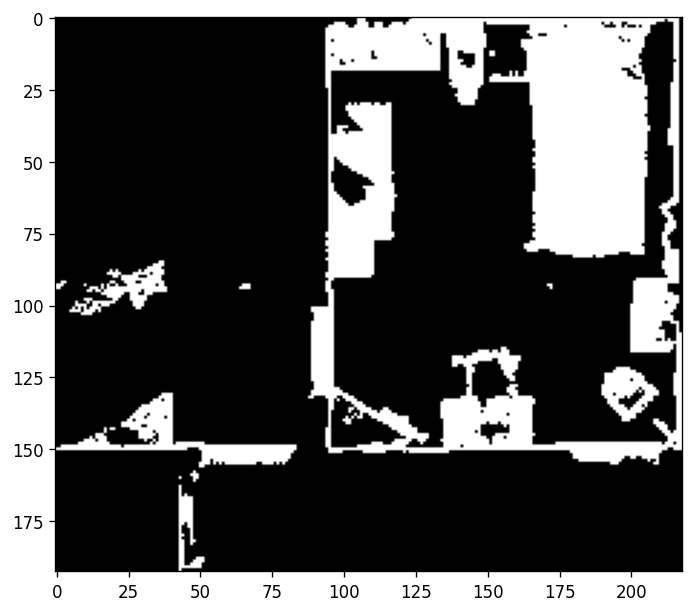

In [6]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 1)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

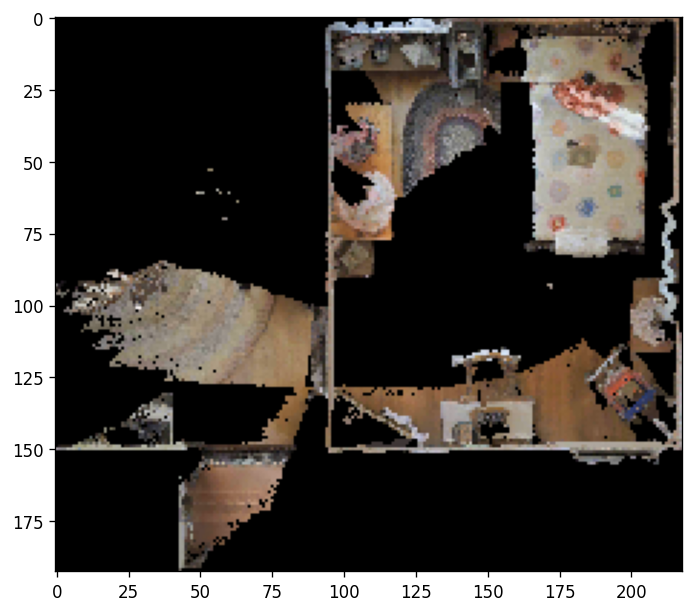

In [7]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()


In [8]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

In [9]:
grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid_save_path)
# grid_save=np.reshape(grid,(1000000,512))
# #print(grid.shape)

# np.savetxt('custom_grid.txt', grid_save, fmt='%02.0f', delimiter=',')v
# #raise Exception("sfdsfsd")
# #grid = grid[xmin:xmax+1, ymin:ymax+1]
# grid_save[0]

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2_mini/map/2t7WUuJeko7_2_mini_dummy/grid_dummy.npy


In [10]:
q_replica = [
    "undefined",
    "base-cabinet",
    "basket",
    "blinds",
    "book",
    "bottle",
    "cabinet",
    "chair",
    "cup",
    "cushion",
    "celling",
    "cooktop",
    "countertop",
    "desk",
    "door",
    "faucet",
    "floor",
    "handrail",
    "indoor-plant",
    "lamp",
    "major-appliance",
    "mat",
    "panel",
    "picture",
    "plant-stand",
    "plate",
    "pot",
    "rack",
    "refrigerator",
    "shower-stall",
    "sink",
    "sofa",
    "stair",
    "stool",
    "switch",
    "table",
    "toilet",
    "vase",
    "wall",
    "wall-cabinet",
    "wall-plug",
    "window",
    "rug"
]

q_replica = [
    "undefined",
    "bin",
    "bottle",
    "camera",
    "chair",
    "clock",
    "cushion",
    "ceiling",
    "door",
    "floor",
    "lamp",
    "panel",
    "sofa",
    "stool",
    "table",
    "tablet",
    "tissue-paper",
    "tv-screen",
    "vent",
    "wall",
    "wall-plug",
    "window"
]
q_replica = [
    'undefined',
    'backpack',
    'base-cabinet',
    'basket',
    'bathtub',
    'beam',
    'beanbag',
    'bed',
    'bench',
    'bike', 
    'bin',
    'blanket', 
    'blinds', 
    'book', 
    'bottle', 
    'box', 
    'bowl', 
    'camera', 
    'cabinet',
    'candle',
    'chair',
    'chopping-board',
    'clock',
    'cloth',
    'clothing',
    'coaster',
    'comforter',
    'computer-keyboard',
    'cup',
    'cushion',
    'curtain',
    'ceiling',
    'cooktop',
    'countertop',
    'desk',
    'desk-organizer',
    'desktop-computer',
    'door',
    'exercise-ball',
    'faucet',
    'floor',
    'handbag',
    'hair-dryer',
    'handrail',
    'indoor-plant',
    'knife-block',
    'kitchen-utensil',
    'lamp', 
    'laptop', 
    'major-appliance', 
    'mat', 
    'microwave', 
    'monitor', 
    'mouse', 
    'nightstand', 
    'pan', 
    'panel', 
    'paper-towel', 
    'phone', 
    'picture', 
    'pillar', 
    'pillow', 
    'pipe', 
    'plant-stand', 
    'plate', 
    'pot', 
    'rack', 
    'refrigerator', 
    'remote-control', 
    'scarf', 
    'sculpture', 
    'shelf', 
    'shoe', 
    'shower-stall', 
    'sink', 
    'small-appliance', 
    'sofa', 
    'stair', 
    'stool', 
    'switch', 
    'table', 
    'table-runner', 
    'tablet', 
    'tissue-paper', 
    'toilet', 
    'toothbrush', 
    'towel', 
    'tv-screen', 
    'tv-stand', 
    'umbrella', 
    'utensil-holder', 
    'vase', 
    'vent', 
    'wall', 
    'wall-cabinet', 
    'wall-plug', 
    'wardrobe', 
    'window', 
    'rug', 
    'logo', 
    'bag', 
    'set-of-clothing']

q_new = [
    "void",
    "base-cabinet",
    "basket",
    "bathtub",
    "beanbag",
    "bed",
    "bench",
    "bike",
    "bin",
    "blanket",
    "blinds",
    "book",
    "bottle",
    "bowl",
    "box",
    "cabinet",
    "camera",
    "candle",
    "ceiling",
    "chair",
    "chopping-board",
    "clock",
    "clothing",
    "comforter",
    "cooktop",
    "countertop",
    "cup",
    "curtain",
    "cushion",
    "desk",
    "desk-organizer",
    "door",
    "faucet",
    "floor", 
    "handbag",
    "handrail",
    "indoor-plant",
    "knife-block",
    "lamp",
    "major-appliance",
    "mat",
    "nightstand",
    "panel",
    "picture",
    "pillar",
    "pillow",
    "pipe",
    "plant-stand",
    "plate",
    "pot",
    "rack",
    "refrigerator",
    "rug",
    "scarf",
    "sculpture",
    "shelf",
    "shoe",
    "shower-stall",
    "sink",
    "small-appliance",
    "sofa",
    "stair",
    "stool",
    "switch",
    "table",
    "tablet",
    "tissue-paper",
    "toilet",
    "tv-screen",
    "tv-stand",
    "umbrella",
    "utensil-holder",
    "vase",
    "vent",
    "wall",
    "wall-cabinet",
    "wall-plug",
    "window"]

(193, 218)
(193, 218)


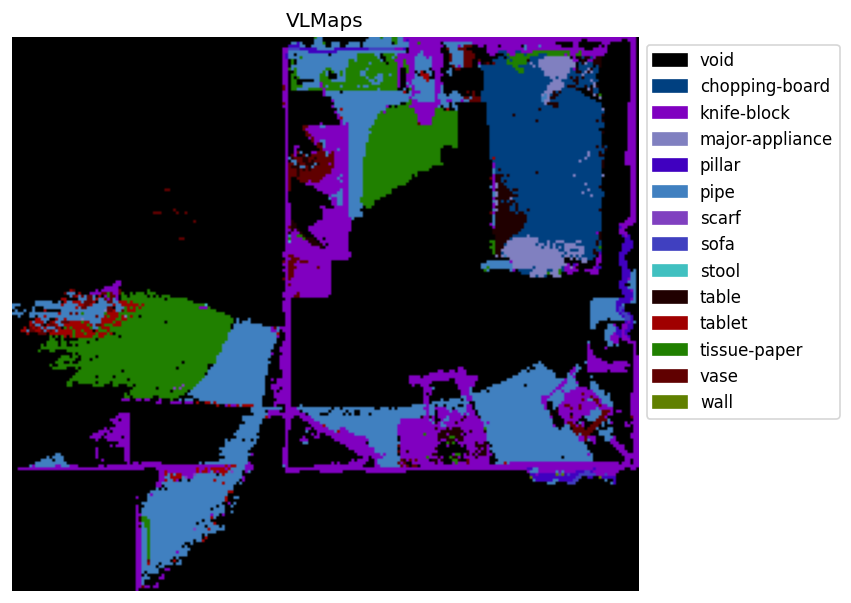

In [11]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] == 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)
print(no_map_mask.shape)

lang = q_new#mp3dcat 
# lang= q_replica
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

# print(type(text_feats))
# print(text_feats.shape)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 16
mask2 = predicts == 0
print(predicts.shape)
new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
# seg[mask2] = [225,225,225,255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [12]:
from seem.base_model import build_vl_model
model = build_vl_model("seem", input_size = 360)

ModuleNotFoundError: No module named 'seem'

In [13]:
# query = ["void","table in the kitchen"]
query = [
    "void",
    "wall",
    "floor",
    "chair",
    "door",
    "table",
    "picture",
    "cabinet",
    "window",
    "sofa",
    "cushion",
    "bed",
    "curtain",
    "chest_of_drawers",
    "plant",
    "sink",
    "stairs",
    "ceiling",
    "toilet",
    "stool",
    "towel",
    "mirror",
    "tv_monitor",
    "shower",
    "column",
    "bathtub",
    "counter",
    "fireplace",
    "lighting",
    "beam",
    "railing",
    "shelving",
    "blinds",
    "gym_equipment",
    "seating",
    "board_panel",
    "furniture",
    "appliances",
    "clothes",
    "objects",
]

q_replica = [
    "undefined",
    "bin",
    "bottle",
    "camera",
    "chair",
    "clock",
    "cushion",
    "ceiling",
    "door",
    "floor",
    "lamp",
    "panel",
    "sofa",
    "stool",
    "table",
    "tablet",
    "tissue-paper",
    "tv-screen",
    "vent",
    "wall",
    "wall-plug",
    "window"
]

q_replica=[
    'undefined',
    'backpack',
    'base-cabinet',
    'basket',
    'bathtub',
    'beam',
    'beanbag',
    'bed',
    'bench',
    'bike', 
    'bin',
    'blanket', 
    'blinds', 
    'book', 
    'bottle', 
    'box', 
    'bowl', 
    'camera', 
    'cabinet',
    'candle',
    'chair',
    'chopping-board',
    'clock',
    'cloth',
    'clothing',
    'coaster',
    'comforter',
    'computer-keyboard',
    'cup',
    'cushion',
    'curtain',
    'ceiling',
    'cooktop',
    'countertop',
    'desk',
    'desk-organizer',
    'desktop-computer',
    'door',
    'exercise-ball',
    'faucet',
    'floor',
    'handbag',
    'hair-dryer',
    'handrail',
    'indoor-plant',
    'knife-block',
    'kitchen-utensil',
    'lamp', 
    'laptop', 
    'major-appliance', 
    'mat', 
    'microwave', 
    'monitor', 
    'mouse', 
    'nightstand', 
    'pan', 
    'panel', 
    'paper-towel', 
    'phone', 
    'picture', 
    'pillar', 
    'pillow', 
    'pipe', 
    'plant-stand', 
    'plate', 
    'pot', 
    'rack', 
    'refrigerator', 
    'remote-control', 
    'scarf', 
    'sculpture', 
    'shelf', 
    'shoe', 
    'shower-stall', 
    'sink', 
    'small-appliance', 
    'sofa', 
    'stair', 
    'stool', 
    'switch', 
    'table', 
    'table-runner', 
    'tablet', 
    'tissue-paper', 
    'toilet', 
    'toothbrush', 
    'towel', 
    'tv-screen', 
    'tv-stand', 
    'umbrella', 
    'utensil-holder', 
    'vase', 
    'vent', 
    'wall', 
    'wall-cabinet', 
    'wall-plug', 
    'wardrobe', 
    'window', 
    'rug', 
    'logo', 
    'bag', 
    'set-of-clothing']

# q_replica = [
#     "undefined",
#     "base-cabinet",
#     "basket",
#     "blinds",
#     "book",
#     "bottle",
#     "cabinet",
#     "chair",
#     "cup",
#     "cushion",
#     "celling",
#     "cooktop",
#     "countertop",
#     "desk",
#     "door",
#     "faucet",
#     "floor",
#     "handrail",
#     "indoor-plant",
#     "lamp",
#     "major-appliance",
#     "mat",
#     "panel",
#     "picture",
#     "plant-stand",
#     "plate",
#     "pot",
#     "rack",
#     "refrigerator",
#     "shower-stall",
#     "sink",
#     "sofa",
#     "stair",
#     "stool",
#     "switch",
#     "table",
#     "toilet",
#     "vase",
#     "wall",
#     "wall-cabinet",
#     "wall-plug",
#     "window",
#     "rug"
# ]
# query = [
#     "void",
#     "wall",
#     "floor",
#     "chair",
#     "door",
#     "table",
#     "picture",
#     "cabinet",
#     "cushion",
#     "window",
#     "sofa",
#     "bed",
#     "curtain",
#     "sink",
#     "stairs"
# ]

# query = [
#     "void",
# #    "floor",
#     "bed_room in a scene"
# ]
# t_emb = model.encode_prompt(query, task="default")

# aa = t_emb.cpu().numpy()
# print(aa.shape)

# query = ["table","computer"]
t_emb = model.encode_prompt(q_new, task="default")
aa = t_emb.cpu().numpy()

print(aa.shape)

# qq = ["computer on the table"]
# tt = model.encode_prompt(qq, task="default")
# bb = tt.cpu().numpy()



(78, 512)


(408, 366)


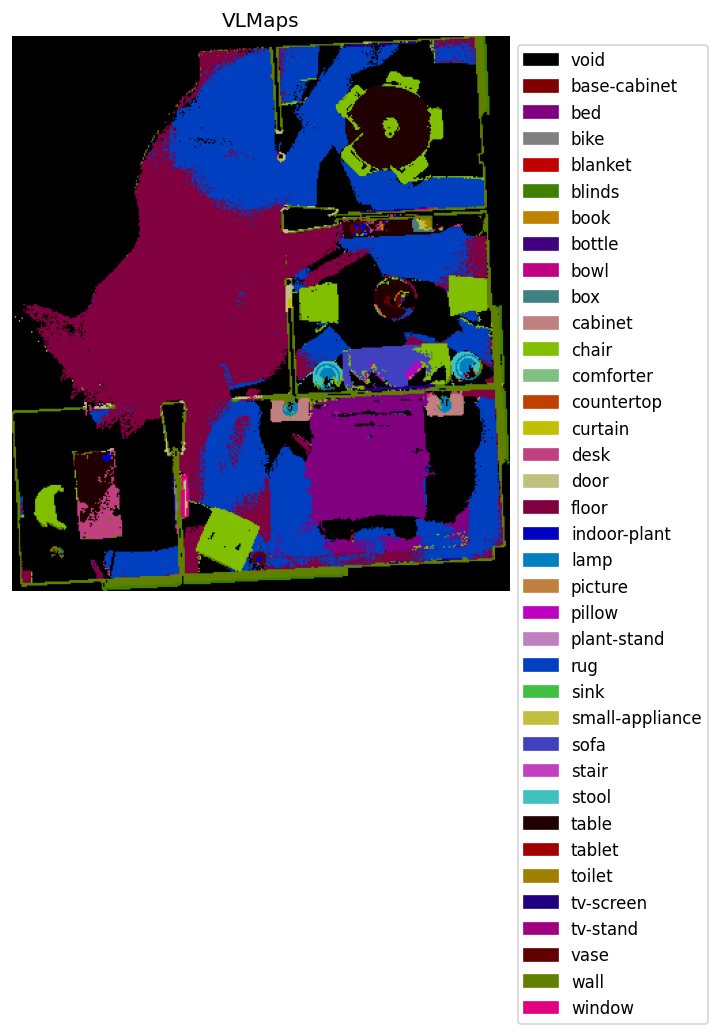

In [16]:

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] ==0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)


map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ aa.T

predicts = np.argmax(scores_list, axis=1)
# for r in range(len(scores_list)):
#     if max(scores_list[r]) < 15:
#         if predicts[r] == 0:
#             continue
#         print("asfasfdsafs")
#         print(max(scores_list[r]))
#         predicts[r] = 0



predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))






floor_mask = predicts == 16
mask2 = predicts == 0
print(predicts.shape)
new_pallete = get_new_pallete(len(q_new))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=q_new)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
# seg[mask2] = [225,225,225,225]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()